In [1]:
%%capture state
from __future__ import division
from __future__ import print_function

import sys, os
sys.path.append('../')

import tensorflow as tf
import numpy as np

from models.neural_network import NeuralNetwork
from models.cnn import CNN

os.environ["CUDA_VISIBLE_DEVICES"] = "0"

#Seed used for all calculations of training and test point indices 
SEED = 14

In [2]:
## Visualization of samples
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline

def visualize(image):
    plt.figure(figsize=(1, 1))
    if image.shape[-1] == 1:
        # image is in black and white
        image = image[:, :, 0]
        plt.imshow(image, cmap='Greys')
    else:
        # image is in color
        plt.imshow(image)
    plt.axis('off')
    plt.show()

#Normalize rows of a given matrix
def normalize(matrix):
    matrix_nm = np.zeros_like(matrix)
    for i in range(matrix.shape[0]):
        matrix_nm[i] = matrix[i]/np.linalg.norm(matrix[i]) 
    return matrix_nm

In [3]:
input_shape = (32, 32,3)
num_classes = 10
eps=0.1

In [4]:
#Load model from disk
model_name = 'SVHN'
model_save_path = '../trained_models/' + model_name + '-model.json'
weights_save_path = '../trained_models/' + model_name + 'weights'
model = CNN(model_name=model_name, dataset='svhn')
print (model.num_params)
model.load_model(model_save_path, weights_save_path) 
#epochs = 150
#model.train(epochs=epochs)
#model.save_model(model_save_path, weights_save_path)   

22247242
Loaded model from disk


In [5]:
#Get training samples
num_train_samples = 1000
data_indices = model.gen_rand_indices(low=0, high=model.train_data.shape[0], seed=SEED, num_samples=num_train_samples)
train_data = model.train_data[data_indices]
train_data_labels = model.train_labels[data_indices]
train_data_labels_int = np.argmax(train_data_labels, axis=1)

In [6]:
num_test_samples_per_class = 10
num_test_samples = num_classes*num_test_samples_per_class

#Generate test points
test_indices = model.gen_rand_indices_all_classes(y=model.test_labels, seed=SEED, num_samples=num_test_samples_per_class)

#Get Regular, Noisy, FGSM, BIM, and CW test points
reg_data = model.test_data[test_indices]
noisy_data = model.generate_perturbed_data(model.test_data[test_indices], model.test_labels[test_indices],seed=SEED, perturbation='Noisy', eps=eps)
fgsm_data = model.generate_perturbed_data(model.test_data[test_indices], model.test_labels[test_indices],seed=SEED, perturbation='FGSM', eps=eps)
bim_a_data = model.generate_perturbed_data(model.test_data[test_indices], model.test_labels[test_indices], seed=SEED, perturbation='BIM-A', iterations=10, eps=eps)
bim_b_data = model.generate_perturbed_data(model.test_data[test_indices], model.test_labels[test_indices], seed=SEED, perturbation='BIM-B', iterations=10, eps=eps)
cw_data = model.generate_perturbed_data(model.test_data[test_indices], model.test_labels[test_indices],seed=SEED, perturbation='CW', targeted=False, eps=eps)
df_data = model.generate_perturbed_data(model.test_data[test_indices], model.test_labels[test_indices],seed=SEED, perturbation='DF')
jsma_data = model.generate_perturbed_data(model.test_data[test_indices], model.test_labels[test_indices],seed=SEED, perturbation='JSMA')

/root/notebook/cleverhans/cleverhans/src/cleverhans/cleverhans/utils_keras.py:144: UserWarning: Please update your version to keras >= 2.1.3; support for earlier keras versions will be dropped on 2018-07-22
  "Please update your version to keras >= 2.1.3; "


In [7]:
#Whitebox CW Attack
#First get guide images
guide_indices = list()
np.random.seed(SEED)
#Generate guide images for modified CW attacks
for idx in test_indices:
    label = np.argmax(model.test_labels[idx])
    #Add 1 to the label mod 10 to get a target label
    mod_label = (label + 1) % num_classes
    #Get a test point with the target label
    guide_imgs_indices = np.where(model.train_labels[:,mod_label] == 1)[0]
    #Choose a guide image
    guide_img_idx = np.random.choice(guide_imgs_indices, 1)[0]
    guide_indices.append(guide_img_idx)


#1 Phase Attack
p1_cw_data = model.generate_perturbed_data(model.test_data[test_indices], model.train_labels[guide_indices],seed=SEED, perturbation='CW', targeted=True, x_tar = model.train_data[guide_indices], use_cos_norm_reg=True, eps=eps)

#2 Phase Attack
#Phase 1: Generate targeted adversarial images
tar_cw_data = model.generate_perturbed_data(model.test_data[test_indices], model.train_labels[guide_indices],seed=SEED, perturbation='CW', targeted=True, use_cos_norm_reg=False, eps=eps)
#Phase 2: Optimize for higher cosine sim and smaller norm of gradient vector
p2_cw_data = model.generate_perturbed_data(tar_cw_data, model.train_labels[guide_indices],seed=SEED, perturbation='CW', targeted=True, x_tar = model.train_data[guide_indices], use_cos_norm_reg=True, eps=eps)

Loss: 11598.84570, Cos: -0.00000, Norm: 1144.81311
Loss: 6345.90381, Cos: -0.00000, Norm: 629.62891
Loss: 5037.24512, Cos: -0.00000, Norm: 499.58670
Loss: 3596.20166, Cos: -0.00000, Norm: 355.72107
Loss: 41.96054, Cos: -0.00000, Norm: 1.35007
Loss: 46.81364, Cos: -0.00000, Norm: 0.89696
Loss: 58.35633, Cos: -0.00000, Norm: 1.07107
Loss: 72.11630, Cos: -0.00000, Norm: 1.47466
Loss: 81.41383, Cos: -0.00000, Norm: 1.46760
Loss: 85.10931, Cos: -0.00000, Norm: 0.95011
Loss: 90.32077, Cos: -0.00000, Norm: 0.64091
Loss: 96.07018, Cos: -0.00000, Norm: 0.44519
Loss: 101.94103, Cos: -0.00000, Norm: 0.32141
Loss: 107.68917, Cos: -0.00000, Norm: 0.24350
Loss: 113.12923, Cos: -0.00000, Norm: 0.19027
Loss: 118.18822, Cos: -0.00000, Norm: 0.15127
Loss: 122.89639, Cos: -0.00000, Norm: 0.12609
Loss: 127.24391, Cos: -0.00000, Norm: 0.11032
Loss: 131.21442, Cos: -0.00000, Norm: 0.09896
Loss: 134.82681, Cos: -0.00000, Norm: 0.09063
Loss: 138.07739, Cos: -0.00000, Norm: 0.08184
Loss: 10128.68555, Cos: -0.0

Loss: 67.68258, Cos: -0.98893, Norm: 0.14894
Loss: 72.22708, Cos: -0.98942, Norm: 0.04456
Loss: 77.22069, Cos: -0.98853, Norm: 0.01687
Loss: 82.08774, Cos: -0.98948, Norm: 0.00745
Loss: 86.66571, Cos: -0.98969, Norm: 0.00366
Loss: 90.92497, Cos: -0.98980, Norm: 0.00199
Loss: 94.85729, Cos: -0.98970, Norm: 0.00119
Loss: 98.47746, Cos: -0.99036, Norm: 0.00076
Loss: 101.76917, Cos: -0.98902, Norm: 0.00053
Loss: 104.76598, Cos: -0.98767, Norm: 0.00039
Loss: 107.51293, Cos: -0.98929, Norm: 0.00027
Loss: 9332.17188, Cos: -1.01598, Norm: 916.03229
Loss: 2810.38257, Cos: -1.00172, Norm: 278.47076
Loss: 131.26189, Cos: -0.98921, Norm: 10.88491
Loss: 69.24164, Cos: -0.98614, Norm: 3.78672
Loss: 46.32506, Cos: -0.98291, Norm: 0.43967
Loss: 54.31744, Cos: -0.98609, Norm: 0.12646
Loss: 64.67283, Cos: -0.98714, Norm: 0.06161
Loss: 75.03806, Cos: -0.98400, Norm: 0.04414
Loss: 84.95893, Cos: -0.98640, Norm: 0.03578
Loss: 94.22331, Cos: -0.98668, Norm: 0.03100
Loss: 102.82407, Cos: -0.98679, Norm: 0.03

Loss: 4319.41016, Cos: -1.00000, Norm: 425.51944
Loss: 5682.04785, Cos: -1.00000, Norm: 553.82507
Loss: 4234.99121, Cos: -1.00000, Norm: 416.18845
Loss: 1432.97949, Cos: -1.00000, Norm: 139.66806
Loss: 899.41559, Cos: -1.00000, Norm: 85.43556
Loss: 66.59872, Cos: -1.00000, Norm: 1.27305
Loss: 63.52205, Cos: -1.00000, Norm: 0.05961
Loss: 71.91865, Cos: -1.00000, Norm: 0.00509
Loss: 80.48944, Cos: -1.00000, Norm: 0.00088
Loss: 88.64730, Cos: -1.00000, Norm: 0.00030
Loss: 96.29784, Cos: -1.00000, Norm: 0.00013
Loss: 103.41304, Cos: -1.00000, Norm: 0.00011
Loss: 109.98868, Cos: -1.00000, Norm: 0.00007
Loss: 116.03743, Cos: -1.00000, Norm: 0.00005
Loss: 121.58018, Cos: -1.00000, Norm: 0.00004
Loss: 126.64294, Cos: -1.00000, Norm: 0.00003
Loss: 131.25427, Cos: -1.00000, Norm: 0.00003
Loss: 135.44382, Cos: -1.00000, Norm: 0.00002
Loss: 139.24097, Cos: -1.00000, Norm: 0.00002
Loss: 142.67438, Cos: -1.00000, Norm: 0.00001
Loss: 8080.31689, Cos: -1.00000, Norm: 791.95172
Loss: 5085.79736, Cos: -

Loss: 1490.18066, Cos: -1.00000, Norm: 144.90173
Loss: 1416.14319, Cos: -1.00000, Norm: 137.83568
Loss: 251.56042, Cos: -1.00000, Norm: 20.57005
Loss: 54.50317, Cos: -1.00000, Norm: 0.03553
Loss: 62.68406, Cos: -1.00000, Norm: 0.00231
Loss: 71.04939, Cos: -1.00000, Norm: 0.00043
Loss: 79.09566, Cos: -1.00000, Norm: 0.00014
Loss: 86.69452, Cos: -1.00000, Norm: 0.00008
Loss: 93.78581, Cos: -1.00000, Norm: 0.00003
Loss: 100.34769, Cos: -1.00000, Norm: 0.00002
Loss: 106.38042, Cos: -1.00000, Norm: 0.00001
Loss: 111.89809, Cos: -1.00000, Norm: 0.00001
Loss: 116.92296, Cos: -1.00000, Norm: 0.00000
Loss: 121.48166, Cos: -1.00000, Norm: 0.00000
Loss: 125.60287, Cos: -1.00000, Norm: 0.00000
Loss: 129.31578, Cos: -1.00000, Norm: 0.00000
Loss: 132.64928, Cos: -1.00000, Norm: 0.00000
Loss: 135.63136, Cos: -1.00000, Norm: 0.00000
Loss: 2050.83008, Cos: -0.00000, Norm: 204.03549
Loss: 3867.74121, Cos: -0.00000, Norm: 385.47897
Loss: 7.09109, Cos: -0.00000, Norm: 0.00021
Loss: 12.39730, Cos: -0.00000

Loss: 117.25310, Cos: -0.98608, Norm: 0.07177
Loss: 120.99527, Cos: -0.98197, Norm: 0.06386
Loss: 124.30235, Cos: -0.97961, Norm: 0.05336
Loss: 127.24737, Cos: -0.97982, Norm: 0.04352
Loss: 129.82477, Cos: -0.97892, Norm: 0.03442
Loss: 132.08020, Cos: -0.97758, Norm: 0.02713
Loss: 12127.56738, Cos: -1.00000, Norm: 1180.85156
Loss: 7533.84473, Cos: -1.00000, Norm: 744.17780
Loss: 1853.99011, Cos: -1.00000, Norm: 181.91107
Loss: 114.68134, Cos: -1.00000, Norm: 8.58328
Loss: 36.99338, Cos: -1.00000, Norm: 0.00533
Loss: 45.87852, Cos: -1.00000, Norm: 0.00100
Loss: 54.97298, Cos: -1.00000, Norm: 0.00071
Loss: 63.88205, Cos: -1.00000, Norm: 0.00143
Loss: 72.39050, Cos: -1.00000, Norm: 0.00295
Loss: 80.37996, Cos: -1.00000, Norm: 0.00506
Loss: 87.78517, Cos: -1.00000, Norm: 0.00693
Loss: 94.58681, Cos: -1.00000, Norm: 0.00883
Loss: 100.77378, Cos: -1.00000, Norm: 0.00969
Loss: 106.37314, Cos: -1.00000, Norm: 0.01063
Loss: 111.40347, Cos: -1.00000, Norm: 0.01098
Loss: 115.89761, Cos: -1.00000,

Loss: 52.52581, Cos: -0.98434, Norm: 0.00445
Loss: 56.05803, Cos: -0.98578, Norm: 0.00209
Loss: 59.37031, Cos: -0.98439, Norm: 0.00109
Loss: 62.46752, Cos: -0.98310, Norm: 0.00083
Loss: 65.35333, Cos: -0.98377, Norm: 0.00073
Loss: 67.99480, Cos: -0.98355, Norm: 0.00062
Loss: 70.39181, Cos: -0.98221, Norm: 0.00056
Loss: 72.56479, Cos: -0.98131, Norm: 0.00050
Loss: 74.53006, Cos: -0.98170, Norm: 0.00048
Loss: 6136.77197, Cos: -0.97539, Norm: 594.91656
Loss: 2662.85474, Cos: -0.91461, Norm: 261.97437
Loss: 1005.28748, Cos: -0.85670, Norm: 97.46938
Loss: 1187.05371, Cos: -0.63175, Norm: 116.76944
Loss: 144.71689, Cos: -0.63434, Norm: 11.93032
Loss: 35.59544, Cos: -0.60554, Norm: 0.38524
Loss: 38.60309, Cos: -0.56635, Norm: 0.03497
Loss: 44.72953, Cos: -0.51424, Norm: 0.00896
Loss: 51.60881, Cos: -0.53390, Norm: 0.00319
Loss: 57.98299, Cos: -0.52635, Norm: 0.00160
Loss: 64.11719, Cos: -0.52782, Norm: 0.00094
Loss: 69.92106, Cos: -0.53359, Norm: 0.00060
Loss: 75.08914, Cos: -0.51502, Norm: 0

Loss: 1002.47412, Cos: -0.96504, Norm: 96.70375
Loss: 2022.85449, Cos: -1.00078, Norm: 198.56728
Loss: 83.99248, Cos: -0.96879, Norm: 4.13659
Loss: 55.59573, Cos: -0.95454, Norm: 0.60074
Loss: 62.34105, Cos: -0.96368, Norm: 0.49307
Loss: 70.48497, Cos: -0.96078, Norm: 0.52035
Loss: 77.59755, Cos: -0.96265, Norm: 0.45107
Loss: 84.48621, Cos: -0.96085, Norm: 0.39140
Loss: 91.59686, Cos: -0.96226, Norm: 0.38875
Loss: 97.69128, Cos: -0.96131, Norm: 0.33050
Loss: 103.05956, Cos: -0.96308, Norm: 0.24300
Loss: 108.09061, Cos: -0.96306, Norm: 0.17010
Loss: 112.76950, Cos: -0.96157, Norm: 0.10916
Loss: 117.23476, Cos: -0.95880, Norm: 0.07221
Loss: 121.52118, Cos: -0.95835, Norm: 0.05715
Loss: 125.45718, Cos: -0.96024, Norm: 0.04455
Loss: 129.00343, Cos: -0.95889, Norm: 0.03368
Loss: 132.27361, Cos: -0.95953, Norm: 0.02830
Loss: 1691.67249, Cos: -0.00000, Norm: 169.16725
Loss: 44.20757, Cos: -0.00000, Norm: 4.03593
Loss: 186.98792, Cos: -0.00000, Norm: 17.63800
Loss: 28.44045, Cos: -0.00000, Nor

Loss: 46.57259, Cos: -1.00000, Norm: 0.48993
Loss: 56.62988, Cos: -1.00000, Norm: 0.65944
Loss: 63.53065, Cos: -1.00000, Norm: 0.53313
Loss: 69.12691, Cos: -1.00000, Norm: 0.31199
Loss: 75.55924, Cos: -1.00000, Norm: 0.21988
Loss: 81.99310, Cos: -1.00000, Norm: 0.17948
Loss: 87.93369, Cos: -1.00000, Norm: 0.14446
Loss: 93.32959, Cos: -1.00000, Norm: 0.11013
Loss: 98.25665, Cos: -1.00000, Norm: 0.08337
Loss: 102.71152, Cos: -1.00000, Norm: 0.06204
Loss: 106.69214, Cos: -1.00000, Norm: 0.04368
Loss: 110.26498, Cos: -1.00000, Norm: 0.03215
Loss: 113.42878, Cos: -1.00000, Norm: 0.02442
Loss: 116.19080, Cos: -1.00000, Norm: 0.01826
Loss: 118.58272, Cos: -1.00000, Norm: 0.01388
Loss: 120.62778, Cos: -1.00000, Norm: 0.01066
Loss: 8192.91309, Cos: -1.00895, Norm: 799.89850
Loss: 3923.44238, Cos: -1.00415, Norm: 388.34641
Loss: 1692.07788, Cos: -1.00320, Norm: 165.33145
Loss: 1204.79565, Cos: -0.99214, Norm: 117.39418
Loss: 50.07743, Cos: -0.98927, Norm: 1.05110
Loss: 49.66453, Cos: -0.99111, N

Loss: 59.32166, Cos: -0.00000, Norm: 0.09960
Loss: 67.19277, Cos: -0.00000, Norm: 0.03424
Loss: 75.08730, Cos: -0.00000, Norm: 0.02098
Loss: 82.51918, Cos: -0.00000, Norm: 0.01671
Loss: 89.39489, Cos: -0.00000, Norm: 0.01377
Loss: 95.71242, Cos: -0.00000, Norm: 0.01135
Loss: 101.48758, Cos: -0.00000, Norm: 0.00911
Loss: 106.75340, Cos: -0.00000, Norm: 0.00767
Loss: 111.53577, Cos: -0.00000, Norm: 0.00658
Loss: 115.86788, Cos: -0.00000, Norm: 0.00594
Loss: 119.77773, Cos: -0.00000, Norm: 0.00536
Loss: 123.29697, Cos: -0.00000, Norm: 0.00488
Loss: 126.45560, Cos: -0.00000, Norm: 0.00452
Loss: 129.28072, Cos: -0.00000, Norm: 0.00416
Loss: 9863.49512, Cos: -1.00228, Norm: 964.36121
Loss: 3554.65015, Cos: -1.00037, Norm: 350.38806
Loss: 1847.13464, Cos: -1.00020, Norm: 179.92566
Loss: 1126.70581, Cos: -0.99879, Norm: 109.42670
Loss: 304.91849, Cos: -0.99802, Norm: 26.40382
Loss: 51.02762, Cos: -0.99786, Norm: 0.02441
Loss: 60.97266, Cos: -0.99799, Norm: 0.00064
Loss: 70.96960, Cos: -0.99831

Loss: 984.00055, Cos: -1.00000, Norm: 89.72522
Loss: 852.67139, Cos: -1.00000, Norm: 76.47372
Loss: 912.43799, Cos: -1.00000, Norm: 81.77999
Loss: 978.77368, Cos: -1.00000, Norm: 87.95107
Loss: 1052.73108, Cos: -1.00000, Norm: 95.03747
Loss: 903.52405, Cos: -1.00000, Norm: 79.89917
Loss: 830.46631, Cos: -1.00000, Norm: 72.10566
Loss: 675.68787, Cos: -1.00000, Norm: 56.16014
Loss: 267.94110, Cos: -1.00000, Norm: 14.93633
Loss: 146.80386, Cos: -1.00000, Norm: 2.38818
Loss: 132.87411, Cos: -1.00000, Norm: 0.58065
Loss: 132.93077, Cos: -1.00000, Norm: 0.19584
Loss: 135.48474, Cos: -1.00000, Norm: 0.08730
Loss: 138.41426, Cos: -1.00000, Norm: 0.04388
Loss: 141.29828, Cos: -1.00000, Norm: 0.02363
Loss: 144.01614, Cos: -1.00000, Norm: 0.01403
Loss: 146.51500, Cos: -1.00000, Norm: 0.00892
Loss: 148.78244, Cos: -1.00000, Norm: 0.00592
Loss: 150.82271, Cos: -1.00000, Norm: 0.00415
Loss: 152.64458, Cos: -1.00000, Norm: 0.00309
Loss: 154.25943, Cos: -1.00000, Norm: 0.00246
Loss: 155.67854, Cos: -1

Loss: 87.66102, Cos: -0.90398, Norm: 0.07215
Loss: 92.91408, Cos: -0.90026, Norm: 0.04635
Loss: 97.91780, Cos: -0.90599, Norm: 0.03076
Loss: 102.51656, Cos: -0.90703, Norm: 0.02184
Loss: 106.77557, Cos: -0.91109, Norm: 0.01607
Loss: 110.61661, Cos: -0.90906, Norm: 0.01228
Loss: 114.09785, Cos: -0.90500, Norm: 0.00981
Loss: 117.28378, Cos: -0.90362, Norm: 0.00798
Loss: 120.15562, Cos: -0.90088, Norm: 0.00666
Loss: 122.74603, Cos: -0.89789, Norm: 0.00578
Loss: 3863.43555, Cos: -1.00482, Norm: 378.79361
Loss: 2455.88794, Cos: -1.00074, Norm: 240.87460
Loss: 2308.03345, Cos: -1.00202, Norm: 225.04239
Loss: 1672.80420, Cos: -0.99966, Norm: 162.56636
Loss: 992.49384, Cos: -0.99485, Norm: 95.18764
Loss: 927.32178, Cos: -0.99725, Norm: 87.96539
Loss: 444.77780, Cos: -0.99655, Norm: 39.21758
Loss: 63.46828, Cos: -0.99487, Norm: 0.37484
Loss: 67.39909, Cos: -0.99567, Norm: 0.04836
Loss: 74.04180, Cos: -0.99577, Norm: 0.01135
Loss: 80.67024, Cos: -0.99565, Norm: 0.00443
Loss: 86.96039, Cos: -0.99

Loss: 5705.66846, Cos: -0.00000, Norm: 563.17157
Loss: 2522.66577, Cos: -0.00000, Norm: 249.78401
Loss: 1168.46973, Cos: -0.00000, Norm: 115.60909
Loss: 786.40186, Cos: -0.00000, Norm: 77.09747
Loss: 21.51797, Cos: -0.00000, Norm: 0.15353
Loss: 30.28722, Cos: -0.00000, Norm: 0.42757
Loss: 40.05757, Cos: -0.00000, Norm: 0.73520
Loss: 46.86818, Cos: -0.00000, Norm: 0.72646
Loss: 55.11689, Cos: -0.00000, Norm: 0.86782
Loss: 61.75794, Cos: -0.00000, Norm: 0.87136
Loss: 66.09280, Cos: -0.00000, Norm: 0.67664
Loss: 71.04041, Cos: -0.00000, Norm: 0.58086
Loss: 75.79938, Cos: -0.00000, Norm: 0.50642
Loss: 79.91982, Cos: -0.00000, Norm: 0.40929
Loss: 83.99757, Cos: -0.00000, Norm: 0.34851
Loss: 87.56055, Cos: -0.00000, Norm: 0.27591
Loss: 90.73488, Cos: -0.00000, Norm: 0.20236
Loss: 93.74521, Cos: -0.00000, Norm: 0.14835
Loss: 96.57430, Cos: -0.00000, Norm: 0.11001
Loss: 99.25219, Cos: -0.00000, Norm: 0.08823
Loss: 101.70811, Cos: -0.00000, Norm: 0.07384
Loss: 4008.49243, Cos: -0.00000, Norm: 3

/usr/local/lib/python2.7/dist-packages/numpy/core/fromnumeric.py:2889: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/usr/local/lib/python2.7/dist-packages/numpy/core/_methods.py:80: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Loss: 6934.03906, Cos: -1.00037, Norm: 681.87103
Loss: 1773.62842, Cos: -0.99929, Norm: 175.86755
Loss: 70.64825, Cos: -0.99858, Norm: 5.22406
Loss: 64.16534, Cos: -0.99878, Norm: 3.95447
Loss: 60.73209, Cos: -0.99896, Norm: 2.88320
Loss: 73.63623, Cos: -0.99903, Norm: 3.40095
Loss: 68.21515, Cos: -0.99914, Norm: 2.08226
Loss: 61.32304, Cos: -0.99916, Norm: 0.63214
Loss: 64.51884, Cos: -0.99914, Norm: 0.21804
Loss: 70.46234, Cos: -0.99918, Norm: 0.11578
Loss: 76.63390, Cos: -0.99919, Norm: 0.07982
Loss: 82.52415, Cos: -0.99919, Norm: 0.06236
Loss: 88.05305, Cos: -0.99923, Norm: 0.05648
Loss: 93.19743, Cos: -0.99926, Norm: 0.05960
Loss: 97.91757, Cos: -0.99924, Norm: 0.06663
Loss: 102.18427, Cos: -0.99925, Norm: 0.07284
Loss: 106.00766, Cos: -0.99928, Norm: 0.07709
Loss: 109.38472, Cos: -0.99928, Norm: 0.07675
Loss: 112.37737, Cos: -0.99927, Norm: 0.07555
Loss: 114.97919, Cos: -0.99928, Norm: 0.07037
Loss: 117.23740, Cos: -0.99927, Norm: 0.06357
Loss: 5808.13672, Cos: -1.00006, Norm: 56

Loss: 80.28366, Cos: -0.00000, Norm: 1.50847
Loss: 77.07422, Cos: -0.00000, Norm: 0.83584
Loss: 1456.65869, Cos: -1.00000, Norm: 144.66586
Loss: 42.13781, Cos: -1.00000, Norm: 2.67607
Loss: 30.45717, Cos: -1.00000, Norm: 0.58558
Loss: 40.22929, Cos: -1.00000, Norm: 0.54045
Loss: 48.23772, Cos: -1.00000, Norm: 0.31280
Loss: 56.83729, Cos: -1.00000, Norm: 0.17639
Loss: 65.87997, Cos: -1.00000, Norm: 0.13795
Loss: 74.31970, Cos: -1.00000, Norm: 0.10302
Loss: 82.26385, Cos: -1.00000, Norm: 0.08667
Loss: 89.51380, Cos: -1.00000, Norm: 0.06984
Loss: 96.08400, Cos: -1.00000, Norm: 0.05237
Loss: 102.01150, Cos: -1.00000, Norm: 0.03529
Loss: 107.37392, Cos: -1.00000, Norm: 0.02307
Loss: 112.20827, Cos: -1.00000, Norm: 0.01585
Loss: 116.53203, Cos: -1.00000, Norm: 0.01164
Loss: 120.36761, Cos: -1.00000, Norm: 0.00893
Loss: 123.74249, Cos: -1.00000, Norm: 0.00677
Loss: 126.69559, Cos: -1.00000, Norm: 0.00548
Loss: 129.25545, Cos: -1.00000, Norm: 0.00451
Loss: 131.45441, Cos: -1.00000, Norm: 0.003

Loss: 55.41735, Cos: -0.99998, Norm: 0.28109
Loss: 65.14173, Cos: -0.99998, Norm: 0.08796
Loss: 75.57877, Cos: -0.99998, Norm: 0.04133
Loss: 85.48315, Cos: -0.99998, Norm: 0.02707
Loss: 94.60699, Cos: -0.99998, Norm: 0.02348
Loss: 102.88834, Cos: -0.99998, Norm: 0.02337
Loss: 110.32667, Cos: -0.99998, Norm: 0.02350
Loss: 116.94852, Cos: -0.99998, Norm: 0.02207
Loss: 122.81931, Cos: -0.99998, Norm: 0.02064
Loss: 127.99313, Cos: -0.99998, Norm: 0.01916
Loss: 132.51645, Cos: -0.99998, Norm: 0.01684
Loss: 136.45142, Cos: -0.99998, Norm: 0.01459
Loss: 139.85352, Cos: -0.99998, Norm: 0.01295
Loss: 142.76712, Cos: -0.99998, Norm: 0.01161
Loss: 145.23781, Cos: -0.99999, Norm: 0.01073
Loss: 147.30237, Cos: -0.99999, Norm: 0.00993
Loss: 149.00110, Cos: -0.99999, Norm: 0.00945
Loss: 1549.66296, Cos: -1.00000, Norm: 153.96629
Loss: 34.58375, Cos: -1.00000, Norm: 1.76680
Loss: 30.78416, Cos: -1.00000, Norm: 0.20212
Loss: 44.85894, Cos: -1.00000, Norm: 0.31458
Loss: 58.06530, Cos: -1.00000, Norm: 0.

Loss: 125.55056, Cos: -1.00000, Norm: 0.01519
Loss: 128.73572, Cos: -1.00000, Norm: 0.01499
Loss: 131.52728, Cos: -1.00000, Norm: 0.01441
Loss: 133.96101, Cos: -1.00000, Norm: 0.01383
Loss: 136.06612, Cos: -1.00000, Norm: 0.01312
Loss: 17.74634, Cos: -1.00000, Norm: 0.77464
Loss: 15.60840, Cos: -1.00000, Norm: 0.00193
Loss: 24.04200, Cos: -1.00000, Norm: 0.02001
Loss: 31.31012, Cos: -1.00000, Norm: 0.00150
Loss: 37.22763, Cos: -1.00000, Norm: 0.00099
Loss: 41.52368, Cos: -1.00000, Norm: 0.00099
Loss: 44.35938, Cos: -1.00000, Norm: 0.00096
Loss: 45.97918, Cos: -1.00000, Norm: 0.00084
Loss: 46.63211, Cos: -1.00000, Norm: 0.00065
Loss: 46.54296, Cos: -1.00000, Norm: 0.00048
Loss: 45.89661, Cos: -1.00000, Norm: 0.00042
Loss: 612.81775, Cos: -0.00000, Norm: 61.28177
Loss: 47.32507, Cos: -0.00000, Norm: 4.24191
Loss: 13.50052, Cos: -0.00000, Norm: 0.02544
Loss: 23.19039, Cos: -0.00000, Norm: 0.05389
Loss: 33.31649, Cos: -0.00000, Norm: 0.11313
Loss: 43.11510, Cos: -0.00000, Norm: 0.16651
Los

Loss: 138.09535, Cos: -1.00001, Norm: 0.01744
Loss: 142.60387, Cos: -1.00001, Norm: 0.01649
Loss: 146.58199, Cos: -1.00001, Norm: 0.01573
Loss: 150.07137, Cos: -1.00001, Norm: 0.01493
Loss: 153.11363, Cos: -1.00001, Norm: 0.01407
Loss: 155.74983, Cos: -1.00001, Norm: 0.01336
Loss: 158.01430, Cos: -1.00001, Norm: 0.01271
Loss: 2398.36792, Cos: -1.04878, Norm: 238.78801
Loss: 29.16899, Cos: -1.01642, Norm: 1.22338
Loss: 29.59440, Cos: -0.94551, Norm: 0.16084
Loss: 42.62294, Cos: -0.92134, Norm: 0.20339
Loss: 57.25910, Cos: -0.92042, Norm: 0.39487
Loss: 68.42414, Cos: -0.95140, Norm: 0.26539
Loss: 78.26135, Cos: -0.95313, Norm: 0.10938
Loss: 87.97907, Cos: -0.93828, Norm: 0.04094
Loss: 97.47120, Cos: -0.93946, Norm: 0.01869
Loss: 106.24610, Cos: -0.93734, Norm: 0.01142
Loss: 114.27774, Cos: -0.93732, Norm: 0.00785
Loss: 121.62321, Cos: -0.94293, Norm: 0.00589
Loss: 128.23213, Cos: -0.94465, Norm: 0.00520
Loss: 134.16492, Cos: -0.94439, Norm: 0.00491
Loss: 139.50589, Cos: -0.94578, Norm: 0

Loss: 76.40678, Cos: -1.00000, Norm: 0.32878
Loss: 78.25522, Cos: -1.00000, Norm: 0.23307
Loss: 80.15185, Cos: -1.00000, Norm: 0.16833
Loss: 82.00798, Cos: -1.00000, Norm: 0.12530
Loss: 83.69476, Cos: -1.00000, Norm: 0.08929
Loss: 85.26534, Cos: -1.00000, Norm: 0.06332
Loss: 86.72602, Cos: -1.00000, Norm: 0.04613
Loss: 2004.81421, Cos: -0.00000, Norm: 200.48141
Loss: 957.27155, Cos: -0.00000, Norm: 95.35764
Loss: 27.59476, Cos: -0.00000, Norm: 1.89843
Loss: 32.65377, Cos: -0.00000, Norm: 1.78763
Loss: 48.70515, Cos: -0.00000, Norm: 2.74190
Loss: 42.11189, Cos: -0.00000, Norm: 1.43901
Loss: 41.65052, Cos: -0.00000, Norm: 0.76985
Loss: 45.10695, Cos: -0.00000, Norm: 0.52286
Loss: 49.31129, Cos: -0.00000, Norm: 0.38628
Loss: 53.62797, Cos: -0.00000, Norm: 0.29910
Loss: 57.91330, Cos: -0.00000, Norm: 0.24773
Loss: 61.95223, Cos: -0.00000, Norm: 0.21019
Loss: 65.62512, Cos: -0.00000, Norm: 0.17332
Loss: 68.95168, Cos: -0.00000, Norm: 0.13748
Loss: 72.01868, Cos: -0.00000, Norm: 0.10961
Loss

Loss: 114.38851, Cos: -0.65697, Norm: 0.00678
Loss: 118.60468, Cos: -0.65869, Norm: 0.00529
Loss: 122.47338, Cos: -0.67021, Norm: 0.00427
Loss: 125.69521, Cos: -0.65870, Norm: 0.00351
Loss: 128.51064, Cos: -0.64497, Norm: 0.00299
Loss: 131.31158, Cos: -0.66509, Norm: 0.00262
Loss: 133.33096, Cos: -0.63994, Norm: 0.00237
Loss: 1868.88135, Cos: -0.74395, Norm: 186.14420
Loss: 62.80285, Cos: -0.80583, Norm: 5.07659
Loss: 17.78851, Cos: -0.58348, Norm: 0.10662
Loss: 23.90910, Cos: -0.45516, Norm: 0.06911
Loss: 32.33366, Cos: -0.44007, Norm: 0.13670
Loss: 40.66488, Cos: -0.46280, Norm: 0.17729
Loss: 47.44445, Cos: -0.44913, Norm: 0.13447
Loss: 54.48919, Cos: -0.50284, Norm: 0.09426
Loss: 60.23664, Cos: -0.46156, Norm: 0.06631
Loss: 65.78769, Cos: -0.43718, Norm: 0.05000
Loss: 71.18963, Cos: -0.43899, Norm: 0.04054
Loss: 76.28090, Cos: -0.45346, Norm: 0.03412
Loss: 80.77530, Cos: -0.45178, Norm: 0.02917
Loss: 84.65395, Cos: -0.42950, Norm: 0.02620
Loss: 88.31813, Cos: -0.42645, Norm: 0.02326

Loss: 122.25197, Cos: -0.96656, Norm: 0.02818
Loss: 125.79393, Cos: -0.96637, Norm: 0.02611
Loss: 128.90253, Cos: -0.96544, Norm: 0.02428
Loss: 131.65143, Cos: -0.96797, Norm: 0.02250
Loss: 134.02214, Cos: -0.96888, Norm: 0.02087
Loss: 136.03616, Cos: -0.96731, Norm: 0.01941
Loss: 190.93204, Cos: -0.97993, Norm: 18.11328
Loss: 12.36472, Cos: -0.98615, Norm: 0.02001
Loss: 16.55889, Cos: -0.98556, Norm: 0.03672
Loss: 21.41994, Cos: -0.98738, Norm: 0.08293
Loss: 25.71202, Cos: -0.98847, Norm: 0.07670
Loss: 30.12553, Cos: -0.99077, Norm: 0.10276
Loss: 33.96056, Cos: -0.99068, Norm: 0.10166
Loss: 37.05985, Cos: -0.98979, Norm: 0.05838
Loss: 39.95308, Cos: -0.98975, Norm: 0.02651
Loss: 42.67400, Cos: -0.98716, Norm: 0.01510
Loss: 45.14089, Cos: -0.98642, Norm: 0.01204
Loss: 47.29235, Cos: -0.98717, Norm: 0.01041
Loss: 49.10917, Cos: -0.98616, Norm: 0.00964
Loss: 50.61723, Cos: -0.98347, Norm: 0.00993
Loss: 51.86329, Cos: -0.98208, Norm: 0.01060
Loss: 52.86395, Cos: -0.98208, Norm: 0.01065
Lo

Loss: 43.77003, Cos: -1.00000, Norm: 0.09293
Loss: 49.10796, Cos: -1.00000, Norm: 0.05914
Loss: 54.25773, Cos: -1.00000, Norm: 0.04251
Loss: 59.08696, Cos: -1.00000, Norm: 0.03379
Loss: 63.53249, Cos: -1.00000, Norm: 0.02861
Loss: 67.56879, Cos: -1.00000, Norm: 0.02473
Loss: 71.20226, Cos: -1.00000, Norm: 0.02225
Loss: 74.42297, Cos: -1.00000, Norm: 0.01878
Loss: 77.26219, Cos: -1.00000, Norm: 0.01544
Loss: 79.75179, Cos: -1.00000, Norm: 0.01300
Loss: 81.92201, Cos: -1.00000, Norm: 0.01195
Loss: 83.78664, Cos: -1.00000, Norm: 0.01112
Loss: 85.37302, Cos: -1.00000, Norm: 0.01067
Loss: 86.70234, Cos: -1.00000, Norm: 0.01020
Loss: 87.80056, Cos: -1.00000, Norm: 0.00992
Loss: 1876.62256, Cos: -0.00000, Norm: 187.66226
Loss: 7.07746, Cos: -0.00000, Norm: 0.07965
Loss: 27.15274, Cos: -0.00000, Norm: 0.98190
Loss: 45.93857, Cos: -0.00000, Norm: 1.65865
Loss: 44.36487, Cos: -0.00000, Norm: 0.31070
Loss: 53.80246, Cos: -0.00000, Norm: 0.10445
Loss: 64.17322, Cos: -0.00000, Norm: 0.05430
Loss: 7

Loss: 88.06063, Cos: -1.00000, Norm: 0.50676
Loss: 94.62198, Cos: -1.00000, Norm: 0.23227
Loss: 102.16086, Cos: -1.00000, Norm: 0.13022
Loss: 109.65390, Cos: -1.00000, Norm: 0.09606
Loss: 116.68137, Cos: -1.00000, Norm: 0.08434
Loss: 123.16869, Cos: -1.00000, Norm: 0.08356
Loss: 129.12701, Cos: -1.00000, Norm: 0.09078
Loss: 134.55728, Cos: -1.00000, Norm: 0.10217
Loss: 139.42470, Cos: -1.00000, Norm: 0.11023
Loss: 143.69423, Cos: -1.00000, Norm: 0.10771
Loss: 147.43530, Cos: -1.00000, Norm: 0.09776
Loss: 150.73975, Cos: -1.00000, Norm: 0.08611
Loss: 153.65964, Cos: -1.00000, Norm: 0.07485
Loss: 156.22194, Cos: -1.00000, Norm: 0.06367
Loss: 40.33648, Cos: -1.00000, Norm: 3.03365
Loss: 26.90351, Cos: -1.00000, Norm: 1.01074
Loss: 26.35541, Cos: -1.00000, Norm: 0.00020
Loss: 36.91016, Cos: -1.00000, Norm: 0.00094
Loss: 46.98568, Cos: -1.00000, Norm: 0.01348
Loss: 56.32319, Cos: -1.00000, Norm: 0.07017
Loss: 63.30216, Cos: -1.00000, Norm: 0.03090
Loss: 69.14973, Cos: -1.00000, Norm: 0.0118

Loss: 107.83528, Cos: -0.99729, Norm: 0.00620
Loss: 109.13834, Cos: -0.99731, Norm: 0.00481
Loss: 110.12111, Cos: -0.99722, Norm: 0.00360
Loss: 1627.18408, Cos: -0.97010, Norm: 161.74832
Loss: 489.76736, Cos: -0.99848, Norm: 47.27540
Loss: 27.59336, Cos: -0.97433, Norm: 0.06698
Loss: 46.90532, Cos: -0.99281, Norm: 0.77960
Loss: 75.49771, Cos: -0.99939, Norm: 2.40504
Loss: 83.62013, Cos: -0.99768, Norm: 2.02702
Loss: 85.42845, Cos: -0.99836, Norm: 1.07662
Loss: 91.57155, Cos: -0.99993, Norm: 0.63237
Loss: 99.45937, Cos: -1.00092, Norm: 0.44204
Loss: 107.26693, Cos: -0.99887, Norm: 0.32568
Loss: 114.62815, Cos: -1.00021, Norm: 0.23736
Loss: 121.47218, Cos: -1.00088, Norm: 0.16996
Loss: 127.81266, Cos: -0.99989, Norm: 0.12100
Loss: 133.72760, Cos: -1.00224, Norm: 0.08828
Loss: 139.12439, Cos: -1.00109, Norm: 0.06446
Loss: 144.08929, Cos: -1.00097, Norm: 0.04886
Loss: 148.62480, Cos: -1.00080, Norm: 0.03841
Loss: 152.75668, Cos: -1.00090, Norm: 0.03129
Loss: 156.49457, Cos: -1.00004, Norm:

Loss: 73.28903, Cos: -0.00000, Norm: 0.00064
Loss: 80.49795, Cos: -0.00000, Norm: 0.00126
Loss: 87.18330, Cos: -0.00000, Norm: 0.00249
Loss: 93.34859, Cos: -0.00000, Norm: 0.00477
Loss: 99.01765, Cos: -0.00000, Norm: 0.00835
Loss: 104.22052, Cos: -0.00000, Norm: 0.01446
Loss: 108.97486, Cos: -0.00000, Norm: 0.02218
Loss: 113.34910, Cos: -0.00000, Norm: 0.03543
Loss: 117.36979, Cos: -0.00000, Norm: 0.05415
Loss: 121.01463, Cos: -0.00000, Norm: 0.07349
Loss: 124.29081, Cos: -0.00000, Norm: 0.09135
Loss: 127.22074, Cos: -0.00000, Norm: 0.10733
Loss: 1524.49231, Cos: -0.99995, Norm: 151.44928
Loss: 133.30055, Cos: -0.99995, Norm: 11.65289
Loss: 75.26993, Cos: -0.99997, Norm: 4.75494
Loss: 57.87619, Cos: -0.99995, Norm: 1.81518
Loss: 71.31133, Cos: -0.99994, Norm: 1.95100
Loss: 88.17380, Cos: -0.99994, Norm: 2.47557
Loss: 89.35693, Cos: -0.99995, Norm: 1.50346
Loss: 92.60001, Cos: -0.99995, Norm: 0.81274
Loss: 98.22843, Cos: -0.99996, Norm: 0.43776
Loss: 105.07368, Cos: -0.99996, Norm: 0.26

In [8]:
#Reset tf.graph() as Cleverhans modifies the graph
tf.reset_default_graph()

#Reload the model and weights
model = CNN(model_name=model_name, dataset='svhn')
model.load_model(model_save_path, weights_save_path)    

Loaded model from disk


In [9]:
print (model.model.evaluate(reg_data,model.test_labels[test_indices]))
print (model.model.evaluate(noisy_data,model.test_labels[test_indices]))
print (model.model.evaluate(fgsm_data,model.test_labels[test_indices]))
print (model.model.evaluate(bim_a_data,model.test_labels[test_indices]))
print (model.model.evaluate(bim_b_data,model.test_labels[test_indices]))
print (model.model.evaluate(cw_data,model.test_labels[test_indices]))
print (model.model.evaluate(df_data,model.test_labels[test_indices]))
print (model.model.evaluate(jsma_data,model.test_labels[test_indices]))
print (model.model.evaluate(p1_cw_data,model.test_labels[test_indices]))
print (model.model.evaluate(p2_cw_data,model.test_labels[test_indices]))

100/100 [==============================] - 0s 928us/step
[0.31380265712738037, 0.94999999999999996]
100/100 [==============================] - 0s 585us/step
[1.5436758947372438, 0.56000000000000005]
100/100 [==============================] - 0s 510us/step
[4.5829721546173099, 0.14000000000000001]
100/100 [==============================] - 0s 515us/step
[4.7205786228179933, 0.0]
100/100 [==============================] - 0s 503us/step
[15.776631011962891, 0.029999999999999999]
100/100 [==============================] - 0s 487us/step
[3.5226074075698852, 0.02]
100/100 [==============================] - 0s 473us/step
[0.99572829008102415, 0.050000000000000003]
100/100 [==============================] - 0s 474us/step
[2.6299167633056642, 0.02]
100/100 [==============================] - 0s 487us/step
[5.6925545597076415, 0.02]
100/100 [==============================] - 0s 467us/step
[4.5471681976318363, 0.0]


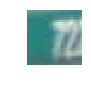

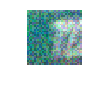

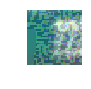

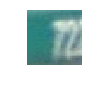

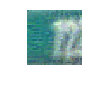

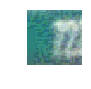

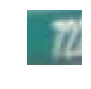

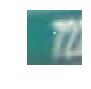

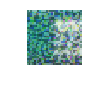

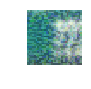

In [10]:
#Lets visualize one sample from each dataset
x_vis = np.random.choice(range(0,num_test_samples), 1)
visualize(reg_data[x_vis].reshape(*input_shape))
visualize(noisy_data[x_vis].reshape(*input_shape))
visualize(fgsm_data[x_vis].reshape(*input_shape))
visualize(bim_a_data[x_vis].reshape(*input_shape))
visualize(bim_b_data[x_vis].reshape(*input_shape))
visualize(cw_data[x_vis].reshape(*input_shape))
visualize(df_data[x_vis].reshape(*input_shape))
visualize(jsma_data[x_vis].reshape(*input_shape))
visualize(p1_cw_data[x_vis].reshape(*input_shape))
visualize(p2_cw_data[x_vis].reshape(*input_shape))

In [11]:
#Get predictions
reg_preds = model.model.predict(reg_data.reshape(-1,*input_shape))
noisy_preds = model.model.predict(noisy_data.reshape(-1,*input_shape))
fgsm_preds = model.model.predict(fgsm_data.reshape(-1,*input_shape))
bim_a_preds = model.model.predict(bim_a_data.reshape(-1,*input_shape))
bim_b_preds = model.model.predict(bim_b_data.reshape(-1,*input_shape))
cw_preds = model.model.predict(cw_data.reshape(-1,*input_shape))
df_preds = model.model.predict(df_data.reshape(-1,*input_shape))
jsma_preds = model.model.predict(jsma_data.reshape(-1,*input_shape))
p1_cw_preds = model.model.predict(p1_cw_data.reshape(-1,*input_shape))
p2_cw_preds = model.model.predict(p2_cw_data.reshape(-1,*input_shape))

In [12]:
#Convert preds to labels
reg_labels = np.zeros(reg_preds.shape)
reg_labels[np.arange(num_test_samples),np.argmax(reg_preds, axis=1)] = 1

noisy_labels = np.zeros(noisy_preds.shape)
noisy_labels[np.arange(num_test_samples),np.argmax(noisy_preds, axis=1)] = 1

fgsm_labels = np.zeros(fgsm_preds.shape)
fgsm_labels[np.arange(num_test_samples),np.argmax(fgsm_preds, axis=1)] = 1

bim_a_labels = np.zeros(bim_a_preds.shape)
bim_a_labels[np.arange(num_test_samples),np.argmax(bim_a_preds, axis=1)] = 1

bim_b_labels = np.zeros(bim_b_preds.shape)
bim_b_labels[np.arange(num_test_samples),np.argmax(bim_b_preds, axis=1)] = 1

cw_labels = np.zeros(cw_preds.shape)
cw_labels[np.arange(num_test_samples),np.argmax(cw_preds, axis=1)] = 1

df_labels = np.zeros(df_preds.shape)
df_labels[np.arange(num_test_samples),np.argmax(df_preds, axis=1)] = 1

jsma_labels = np.zeros(jsma_preds.shape)
jsma_labels[np.arange(num_test_samples),np.argmax(jsma_preds, axis=1)] = 1

p1_cw_labels = np.zeros(p1_cw_preds.shape)
p1_cw_labels[np.arange(num_test_samples),np.argmax(p1_cw_preds, axis=1)] = 1

p2_cw_labels = np.zeros(p2_cw_preds.shape)
p2_cw_labels[np.arange(num_test_samples),np.argmax(p2_cw_preds, axis=1)] = 1

In [13]:
#Check preds to ensure adversarial samples were generated correctly
print (np.argmax(reg_preds, axis=1))
print (np.argmax(noisy_preds, axis=1))
print (np.argmax(fgsm_preds, axis=1))
print (np.argmax(bim_a_preds, axis=1))
print (np.argmax(bim_b_preds, axis=1))
print (np.argmax(cw_preds, axis=1))
print (np.argmax(df_preds, axis=1))
print (np.argmax(jsma_preds, axis=1))
print (np.argmax(p1_cw_preds, axis=1))
print (np.argmax(p2_cw_preds, axis=1))

[0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 2 2 2 2 2 2 2 2 2 2 3 3 3 3 3 3 3
 3 3 3 4 4 4 4 4 4 4 4 4 4 5 5 6 5 5 5 5 5 5 5 6 6 6 6 8 6 6 6 6 6 1 1 7 7
 7 7 7 7 7 7 8 8 8 8 8 8 8 8 8 8 9 9 9 4 9 9 9 9 9 9]
[0 2 1 8 4 2 2 0 2 2 1 1 1 1 4 1 1 1 1 1 5 4 2 3 1 2 7 2 2 2 7 3 1 1 3 3 2
 3 3 3 4 4 4 7 4 4 4 4 4 4 5 5 6 5 5 4 5 5 5 5 6 1 6 5 4 6 4 1 1 6 1 1 1 5
 7 7 1 1 7 7 8 1 8 2 4 3 8 2 8 8 2 1 9 5 2 9 7 9 2 9]
[5 9 4 5 3 4 9 1 2 3 3 3 1 2 9 2 3 1 1 4 1 4 1 5 3 4 7 4 2 3 3 3 1 1 3 2 5
 8 2 3 4 2 3 5 9 1 4 5 4 3 4 3 2 3 3 2 5 4 3 5 5 4 3 5 4 5 4 1 1 5 1 1 1 5
 2 1 1 3 2 3 4 1 3 1 1 1 2 1 9 3 5 4 4 2 3 9 3 2 8 4]
[6 9 9 6 8 9 9 1 9 9 2 2 8 2 3 2 0 0 4 0 8 3 5 3 8 9 7 1 3 5 5 8 2 2 8 8 5
 8 2 5 1 9 3 7 9 1 3 1 3 9 6 3 6 6 3 6 6 6 3 6 5 9 8 5 8 5 5 0 5 5 1 1 1 2
 1 1 1 1 1 2 6 9 3 1 6 6 9 2 9 3 8 2 8 4 2 0 5 0 8 5]
[5 9 9 5 8 9 9 1 4 9 2 2 8 8 3 2 0 0 4 6 5 3 5 3 8 9 7 1 3 5 5 8 4 2 8 9 5
 8 2 5 0 9 3 7 9 1 3 3 3 9 6 8 5 6 3 6 6 6 7 6 5 9 3 5 6 5 5 0 5 5 3 0 1 8
 8 4 9 6 1 2 4 4 3 1 6 6 9 2 9 3 8

In [14]:
#Get gradients for all test points
grads_reg = model.get_gradients_wrt_params(reg_data, reg_labels)
grads_noisy = model.get_gradients_wrt_params(noisy_data, noisy_labels)
grads_fgsm = model.get_gradients_wrt_params(fgsm_data, fgsm_labels)
grads_bim_a = model.get_gradients_wrt_params(bim_a_data, bim_a_labels)
grads_bim_b = model.get_gradients_wrt_params(bim_b_data, bim_b_labels)
grads_cw = model.get_gradients_wrt_params(cw_data, cw_labels)
grads_df = model.get_gradients_wrt_params(df_data, df_labels)
grads_jsma = model.get_gradients_wrt_params(jsma_data, jsma_labels)
grads_p1_cw = model.get_gradients_wrt_params(p1_cw_data, p1_cw_labels)
grads_p2_cw = model.get_gradients_wrt_params(p2_cw_data, p2_cw_labels)

#Get gradients for training points 
grads_train = model.get_gradients_wrt_params(train_data, train_data_labels)

In [15]:
grads_reg_nm = normalize(grads_reg)
grads_noisy_nm = normalize(grads_noisy)
grads_fgsm_nm = normalize(grads_fgsm)
grads_bim_a_nm = normalize(grads_bim_a)
grads_bim_b_nm = normalize(grads_bim_b)
grads_cw_nm = normalize(grads_cw)
grads_df_nm = normalize(grads_df)
grads_jsma_nm = normalize(grads_jsma)
grads_p1_cw_nm = normalize(grads_p1_cw)
grads_p2_cw_nm = normalize(grads_p2_cw)
#grads_train_nm = normalize(grads_train)

MemoryError: 

In [20]:
#Get norms 
grads_reg_norms = np.sqrt(np.dot(grads_reg, grads_reg.T)).diagonal()
grads_noisy_norms = np.sqrt(np.dot(grads_noisy, grads_noisy.T)).diagonal()
grads_bim_a_norms = np.sqrt(np.dot(grads_bim_a, grads_bim_b.T)).diagonal()
grads_bim_b_norms = np.sqrt(np.dot(grads_bim_b, grads_bim_b.T)).diagonal()
grads_fgsm_norms = np.sqrt(np.dot(grads_fgsm, grads_fgsm.T)).diagonal()
grads_cw_norms = np.sqrt(np.dot(grads_cw, grads_cw.T)).diagonal()
grads_df_norms = np.sqrt(np.dot(grads_df, grads_df.T)).diagonal()
grads_jsma_norms = np.sqrt(np.dot(grads_jsma, grads_jsma.T)).diagonal()
grads_p1_cw_norms = np.sqrt(np.dot(grads_p1_cw, grads_p1_cw.T)).diagonal()
grads_p2_cw_norms = np.sqrt(np.dot(grads_p2_cw, grads_p2_cw.T)).diagonal()

/usr/local/lib/python2.7/dist-packages/ipykernel_launcher.py:2: RuntimeWarning: invalid value encountered in sqrt
  
/usr/local/lib/python2.7/dist-packages/ipykernel_launcher.py:3: RuntimeWarning: invalid value encountered in sqrt
  This is separate from the ipykernel package so we can avoid doing imports until
/usr/local/lib/python2.7/dist-packages/ipykernel_launcher.py:4: RuntimeWarning: invalid value encountered in sqrt
  after removing the cwd from sys.path.
/usr/local/lib/python2.7/dist-packages/ipykernel_launcher.py:5: RuntimeWarning: invalid value encountered in sqrt
  """
/usr/local/lib/python2.7/dist-packages/ipykernel_launcher.py:6: RuntimeWarning: invalid value encountered in sqrt
  
/usr/local/lib/python2.7/dist-packages/ipykernel_launcher.py:7: RuntimeWarning: invalid value encountered in sqrt
  import sys
/usr/local/lib/python2.7/dist-packages/ipykernel_launcher.py:8: RuntimeWarning: invalid value encountered in sqrt
  
/usr/local/lib/python2.7/dist-packages/ipykernel_lau

In [21]:
#Hack to bypass memory issue
for i in range(grads_train.shape[0]):
    grads_train[i] = grads_train[i] / np.linalg.norm(grads_train[i])

In [22]:
#Get cosine similarity matrix
cos_sim_reg = np.dot(grads_reg_nm, grads_train.T)
cos_sim_noisy = np.dot(grads_noisy_nm, grads_train.T)
cos_sim_fgsm = np.dot(grads_fgsm_nm, grads_train.T)
cos_sim_bim_a = np.dot(grads_bim_a_nm, grads_train.T)
cos_sim_bim_b = np.dot(grads_bim_b_nm, grads_train.T)
cos_sim_cw = np.dot(grads_cw_nm, grads_train.T)
cos_sim_df = np.dot(grads_df_nm, grads_train.T)
cos_sim_jsma = np.dot(grads_jsma_nm, grads_train.T)
cos_sim_p1_cw = np.dot(grads_p1_cw_nm, grads_train.T)
cos_sim_p2_cw = np.dot(grads_p2_cw_nm, grads_train.T)

In [23]:
#Separate Using Cos Sim
eta = 0.50

count = 0.0
for i in range(num_test_samples):
    if np.max(cos_sim_reg[i]) > eta:
        count+=1.0
        
print ('Regular: %.4f' % ( count/num_test_samples))

count = 0.0
for i in range(num_test_samples):
    if np.max(cos_sim_noisy[i]) > eta:
        count+=1.0
    
print ('Noisy:  %.4f' % ( count/num_test_samples))

count=0.0
for i in range(num_test_samples):
    if np.max(cos_sim_fgsm[i]) > eta:
        count+=1.0
        
print ('FGSM:  %.4f' % ( count/num_test_samples))

count=0.0
for i in range(num_test_samples):
    if np.max(cos_sim_bim_a[i]) > eta:
        count+=1.0
        
print ('BIM-A:  %.4f' % ( count/num_test_samples))

count=0.0
for i in range(num_test_samples):
    if np.max(cos_sim_bim_b[i]) > eta:
        count+=1.0
        
print ('BIM-B:  %.4f' % ( count/num_test_samples))

count=0.0
for i in range(num_test_samples):
    if np.max(cos_sim_cw[i]) > eta:
        count+=1.0
    
print ('CW: %.4f' % ( count/num_test_samples))

count=0.0
for i in range(num_test_samples):
    if np.max(cos_sim_df[i]) > eta:
        count+=1.0
    
print ('DF: %.4f' % ( count/num_test_samples))

count=0.0
for i in range(num_test_samples):
    if np.max(cos_sim_jsma[i]) > eta:
        count+=1.0
    
print ('JSMA: %.4f' % ( count/num_test_samples))

count = 0.0
for i in range(num_test_samples):
    if np.max(cos_sim_p1_cw[i]) > eta:
        count+=1.0
        
print ('1 Phase CW:  %.4f' % ( count/num_test_samples))

count = 0.0
for i in range(num_test_samples):
    if np.max(cos_sim_p2_cw[i]) > eta:
        count+=1.0
        
print ('2 Phase CW:  %.4f' % ( count/num_test_samples))



Regular: 0.8500
Noisy:  0.3300
FGSM:  0.1500
BIM-A:  0.5900
BIM-B:  0.7600
CW: 0.3700
DF: 0.2800
JSMA: 0.2400
1 Phase CW:  0.4000
2 Phase CW:  0.3800


In [24]:
#Separate using just norm
gamma = 50

count = 0.0
for i in range(num_test_samples):
    if grads_reg_norms[i] < gamma:
        count+=1.0
        
print ('Regular: %.4f' % ( count/num_test_samples))

count = 0.0
for i in range(num_test_samples):
    if grads_noisy_norms[i] < gamma:
        count+=1.0
    
print ('Noisy:  %.4f' % ( count/num_test_samples))

count=0.0
for i in range(num_test_samples):
    if grads_fgsm_norms[i] < gamma:
        count+=1.0
        
print ('FGSM:  %.4f' % ( count/num_test_samples))

count=0.0
for i in range(num_test_samples):
    if grads_bim_a_norms[i] < gamma:
        count+=1.0
        
print ('BIM-A:  %.4f' % ( count/num_test_samples))

count=0.0
for i in range(num_test_samples):
    if grads_bim_b_norms[i] < gamma:
        count+=1.0
        
print ('BIM-B:  %.4f' % ( count/num_test_samples))

count=0.0
for i in range(num_test_samples):
    if grads_cw_norms[i] < gamma:
        count+=1.0
    
print ('CW: %.4f' % ( count/num_test_samples))

count=0.0
for i in range(num_test_samples):
    if grads_df_norms[i] < gamma:
        count+=1.0
    
print ('DF: %.4f' % ( count/num_test_samples))

count=0.0
for i in range(num_test_samples):
    if grads_jsma_norms[i] < gamma:
        count+=1.0
    
print ('JSMA: %.4f' % ( count/num_test_samples))

count=0.0
for i in range(num_test_samples):
    if grads_p1_cw_norms[i] < gamma:
        count+=1.0
    
print ('1 Phase CW: %.4f' % ( count/num_test_samples))

count=0.0
for i in range(num_test_samples):
    if grads_p2_cw_norms[i] < gamma:
        count+=1.0
    
print ('2 Phase CW: %.4f' % ( count/num_test_samples))


Regular: 0.8400
Noisy:  0.2500
FGSM:  0.1400
BIM-A:  0.9000
BIM-B:  1.0000
CW: 0.2600
DF: 0.0000
JSMA: 0.0500
1 Phase CW: 0.3400
2 Phase CW: 0.2600


In [25]:
#Use both cos and norm

count = 0.0
for i in range(num_test_samples):
    if np.max(cos_sim_reg[i]) > eta and grads_reg_norms[i] < gamma:
        count+=1.0
        
print ('Regular: %.4f' % ( count/num_test_samples))

count = 0.0
for i in range(num_test_samples):
    if np.max(cos_sim_noisy[i]) > eta and grads_noisy_norms[i] < gamma:
        count+=1.0
    
print ('Noisy:  %.4f' % ( count/num_test_samples))

count=0.0
for i in range(num_test_samples):
    if np.max(cos_sim_fgsm[i]) > eta and grads_fgsm_norms[i] < gamma:
        count+=1.0
        
print ('FGSM:  %.4f' % ( count/num_test_samples))

count=0.0
for i in range(num_test_samples):
    if np.max(cos_sim_bim_a[i]) > eta and grads_bim_a_norms[i] < gamma:
        count+=1.0
        
print ('BIM-A:  %.4f' % ( count/num_test_samples))

count=0.0
for i in range(num_test_samples):
    if np.max(cos_sim_bim_b[i]) > eta and grads_bim_b_norms[i] < gamma:
        count+=1.0
        
print ('BIM-B:  %.4f' % ( count/num_test_samples))
count=0.0
for i in range(num_test_samples):
    if np.max(cos_sim_cw[i]) > eta and grads_cw_norms[i] < gamma:
        count+=1.0
    
print ('CW: %.4f' % ( count/num_test_samples))

count=0.0
for i in range(num_test_samples):
    if np.max(cos_sim_df[i]) > eta and grads_df_norms[i] < gamma:
        count+=1.0
    
print ('DF: %.4f' % ( count/num_test_samples))

count=0.0
for i in range(num_test_samples):
    if np.max(cos_sim_jsma[i]) > eta and grads_jsma_norms[i] < gamma:
        count+=1.0
    
print ('JSMA: %.4f' % ( count/num_test_samples))


count=0.0
for i in range(num_test_samples):
    if np.max(cos_sim_p1_cw[i]) > eta and grads_p1_cw_norms[i] < gamma:
        count+=1.0
    
print ('1 Phase CW: %.4f' % ( count/num_test_samples))

count=0.0
for i in range(num_test_samples):
    if np.max(cos_sim_p2_cw[i]) > eta and grads_p2_cw_norms[i] < gamma:
        count+=1.0
    
print ('2 Phase CW: %.4f' % ( count/num_test_samples))


Regular: 0.7900
Noisy:  0.1800
FGSM:  0.0600
BIM-A:  0.5400
BIM-B:  0.7600
CW: 0.1400
DF: 0.0000
JSMA: 0.0000
1 Phase CW: 0.1900
2 Phase CW: 0.0800


In [26]:
def avg_l2_distortion(orig, adv):
    """Get the mean l2 distortion between two orig and adv images"""
    l2_dist = 0.0
    for i in range(orig.shape[0]):
        l2_dist+= np.linalg.norm(orig[i] - adv[i])
    return l2_dist/orig.shape[0]

In [27]:
print (avg_l2_distortion(reg_data, noisy_data))
print (avg_l2_distortion(reg_data, fgsm_data))
print (avg_l2_distortion(reg_data, bim_a_data))
print (avg_l2_distortion(reg_data, bim_b_data))
print (avg_l2_distortion(reg_data, cw_data))
print (avg_l2_distortion(reg_data, df_data))
print (avg_l2_distortion(reg_data, jsma_data))
print (avg_l2_distortion(reg_data, p1_cw_data))
print (avg_l2_distortion(reg_data, p2_cw_data))

5.47048216553
5.44330807209
0.716128736138
2.51261104822
1.67023386329
0.197508119514
2.66248851895
4.05375030039
2.19328825733


In [28]:
count = 0.0
for i in range(num_test_samples):
    if np.max(cos_sim_noisy[i]) > np.max(cos_sim_reg[i]):
        count+=1.0
    
print ('Noisy:  %.4f' % ( count/num_test_samples))

count=0.0
for i in range(num_test_samples):
    if np.max(cos_sim_fgsm[i]) > np.max(cos_sim_reg[i]):
        count+=1.0
        
print ('FGSM:  %.4f' % ( count/num_test_samples))

count=0.0
for i in range(num_test_samples):
    if np.max(cos_sim_bim_a[i])> np.max(cos_sim_reg[i]):
        count+=1.0
        
print ('BIM-A:  %.4f' % ( count/num_test_samples))

count=0.0
for i in range(num_test_samples):
    if np.max(cos_sim_bim_b[i]) > np.max(cos_sim_reg[i]):
        count+=1.0
        
print ('BIM-B:  %.4f' % ( count/num_test_samples))

count=0.0
for i in range(num_test_samples):
    if np.max(cos_sim_cw[i]) > np.max(cos_sim_reg[i]):
        count+=1.0
    
print ('CW: %.4f' % ( count/num_test_samples))

count=0.0
for i in range(num_test_samples):
    if np.max(cos_sim_df[i]) > np.max(cos_sim_reg[i]):
        count+=1.0
    
print ('DF: %.4f' % ( count/num_test_samples))

count=0.0
for i in range(num_test_samples):
    if np.max(cos_sim_jsma[i]) > np.max(cos_sim_reg[i]):
        count+=1.0
    
print ('JSMA: %.4f' % ( count/num_test_samples))


count = 0.0
for i in range(num_test_samples):
    if np.max(cos_sim_p1_cw[i]) > np.max(cos_sim_reg[i]):
        count+=1.0
        
print ('1 Phase CW:  %.4f' % ( count/num_test_samples))

count = 0.0
for i in range(num_test_samples):
    if np.max(cos_sim_p2_cw[i]) > np.max(cos_sim_reg[i]):
        count+=1.0
        
print ('2 Phase CW:  %.4f' % ( count/num_test_samples))



Noisy:  0.1300
FGSM:  0.0800
BIM-A:  0.2500
BIM-B:  0.2300
CW: 0.1400
DF: 0.1200
JSMA: 0.0800
1 Phase CW:  0.1200
2 Phase CW:  0.0800


In [29]:
count = 0.0
for i in range(num_test_samples):
    if grads_noisy_norms[i] < grads_reg_norms[i]:
        count+=1.0
    
print ('Noisy:  %.4f' % ( count/num_test_samples))

count=0.0
for i in range(num_test_samples):
    if grads_fgsm_norms[i] < grads_reg_norms[i]:
        count+=1.0
        
print ('FGSM:  %.4f' % ( count/num_test_samples))

count=0.0
for i in range(num_test_samples):
    if grads_bim_a_norms[i] < grads_reg_norms[i]:
        count+=1.0
        
print ('BIM-A:  %.4f' % ( count/num_test_samples))

count=0.0
for i in range(num_test_samples):
    if grads_bim_b_norms[i] < grads_reg_norms[i]:
        count+=1.0
        
print ('BIM-B:  %.4f' % ( count/num_test_samples))

count=0.0
for i in range(num_test_samples):
    if grads_cw_norms[i] < grads_reg_norms[i]:
        count+=1.0
    
print ('CW: %.4f' % ( count/num_test_samples))

count=0.0
for i in range(num_test_samples):
    if grads_df_norms[i] < grads_reg_norms[i]:
        count+=1.0
    
print ('DF: %.4f' % ( count/num_test_samples))

count=0.0
for i in range(num_test_samples):
    if grads_jsma_norms[i] < grads_reg_norms[i]:
        count+=1.0
    
print ('JSMA: %.4f' % ( count/num_test_samples))

count=0.0
for i in range(num_test_samples):
    if grads_p1_cw_norms[i] <grads_reg_norms[i]:
        count+=1.0
    
print ('1 Phase CW: %.4f' % ( count/num_test_samples))

count=0.0
for i in range(num_test_samples):
    if grads_p2_cw_norms[i] < grads_reg_norms[i]:
        count+=1.0
    
print ('2 Phase CW: %.4f' % ( count/num_test_samples))

Noisy:  0.0800
FGSM:  0.0900
BIM-A:  0.7300
BIM-B:  0.8900
CW: 0.1800
DF: 0.0200
JSMA: 0.0500
1 Phase CW: 0.1600
2 Phase CW: 0.1400
